In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.data import shepp_logan_phantom
from tqdm.notebook import tqdm

## Q2

In [1]:
def create_Ghx(kernel_size, hx):
    Ghx = np.zeros((kernel_size, kernel_size))

    for i in range(kernel_size):
        for j in range(kernel_size):
            Ghx[i, j] = (i - kernel_size // 2) ** 2 + (j - kernel_size // 2) ** 2

    Ghx = np.exp(-Ghx / (2 * hx ** 2))
    return Ghx

def filter_img(img, kernel):
    norm = np.sum(kernel)
    kernel = kernel / norm
    filtered_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return filtered_img

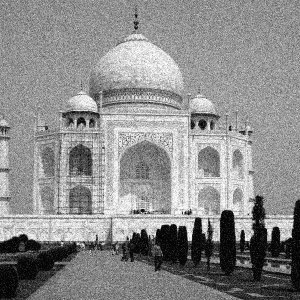

In [3]:
img = cv2.imread('q2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

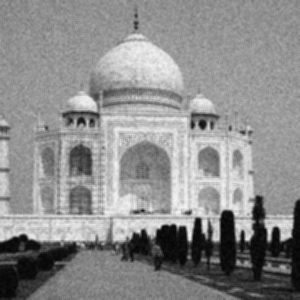

In [4]:
kernel_size = 3

hx = 0.02 * img.shape[0]
Ghx = create_Ghx(kernel_size, hx)

denoise_img = filter_img(img, kernel=Ghx)

cv2_imshow(denoise_img)

In [5]:
def bilateral(img, hg, hx=None, kernel_size=3):
    if hx is None:
        hx = 0.02 * img.shape[0]
    Ghx = create_Ghx(kernel_size, hx)

    pad = kernel_size // 2
    pad_img = np.zeros((img.shape[0] + 2 * pad, img.shape[1] + 2 * pad))
    pad_img[pad:-pad, pad:-pad] = img

    filtered_img = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            ii = i + pad
            jj = j + pad
            window = pad_img[ii-pad:ii+pad+1, jj-pad:jj+pad+1]
            Ghg = np.exp(-(img[i, j] - window) ** 2 / (2 * hg ** 2))
            factor = Ghx * Ghg
            filtered_img[i, j] = np.sum(window * factor) / np.sum(factor)
    return filtered_img

def PSNR(img1, img2, max_pixel_value=255):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

A bilateral filter is a smoothing filter for images that preserves edges and reduces noise. It has two parameters: $h_x$ and $h_g$. $h_x$ is the spatial parameter that controls the size of the filter kernel. $h_g$ is the range parameter that controls how much the filter is influenced by intensity differences. Choosing $h_x$ and $h_g$ depends on the image characteristics and the desired effect. Generally, larger values of $h_x$ and $h_g$ will produce more smoothing, but may also blur edges or create artifacts. Smaller values of $h_x$ and hg will preserve more details, but may also retain more noise. A common practice is to use $h_x = h_g = σ$, where $σ$ is the standard deviation of the Gaussian distribution used for weighting.

Another way to choose $h_x$ and $h_g$ for the bilateral filter is to use $σ_d$ and $σ_r$, which are equivalent to $h_x$ and $h_g$ respectively. $σ_d$ is the spatial standard deviation and $σ_r$ is the range standard deviation. As $σ_r$ increases, the bilateral filter becomes closer to Gaussian blur because the range Gaussian is flatter. As $σ_d$ increases, the bilateral filter smooths larger features. A good choice of $σ_d$ and $σ_r$ depends on the image resolution and noise level. A possible method is to use $σ_d = 2\%$ of the image diagonal and $σ_r = 5\%$ of the intensity range.

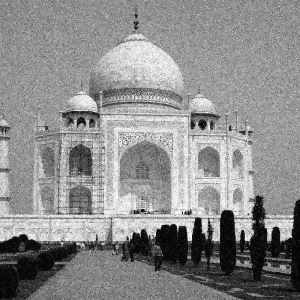

In [17]:
kernel_size = 3

hx = 0.02 * img.shape[0]
hg = 0.05 * 255

denoise_bilateral_img = bilateral(img, hg=hg, hx=hx, kernel_size=3)

cv2_imshow(denoise_bilateral_img)

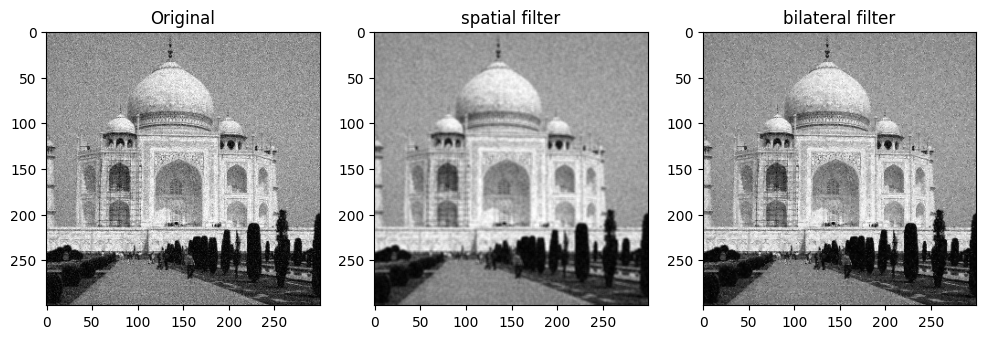

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, 'gray')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(denoise_img, 'gray')
plt.title('spatial filter')

plt.subplot(1, 3, 3)
plt.imshow(denoise_bilateral_img, 'gray')
plt.title('bilateral filter')

plt.show()

In [22]:
def show_kernel(img, index, hx, hg, kernel_size=3):
    Ghx = create_Ghx(kernel_size, hx)

    pad = kernel_size // 2
    padded_image = np.pad(img, kernel_size, mode='symmetric')

    i, j = index
    ii = i + pad
    jj = j + pad

    window = padded_image[ii-pad:ii+pad+1, jj-pad:jj+pad+1]
    Ghg = np.exp(-(img[i, j] - window) ** 2 / (2 * hg ** 2))
    factor = Ghx * Ghg

    factor /= np.sum(factor)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(window, 'gray')
    plt.title(f'{index} index of image')
    plt.subplot(1, 2, 2)
    plt.imshow(factor, 'gray')
    plt.title(f'{index} kernel')
    plt.show()

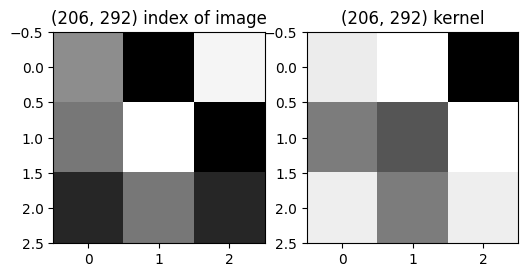

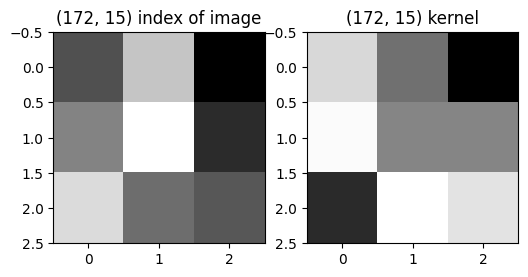

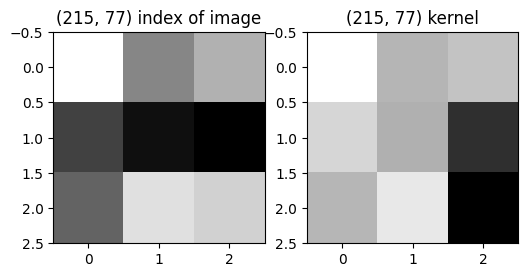

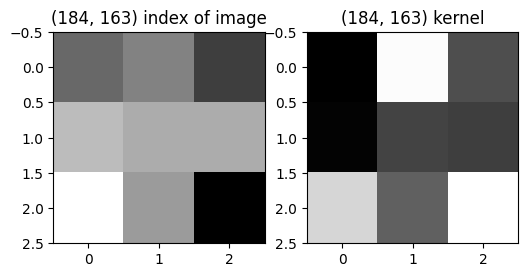

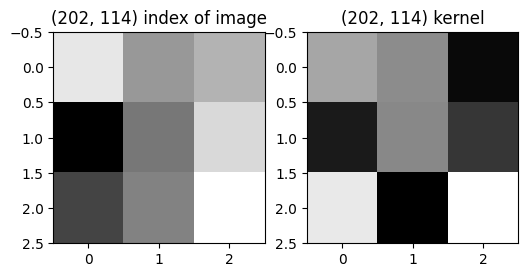

In [23]:
for i in range(5):
    i_index = np.random.randint(0, img.shape[0])
    j_index = np.random.randint(0, img.shape[1])
    show_kernel(img, (i_index, j_index), hx, hg, kernel_size=3)

In bilateral filtering, a window of pixels is selected around each pixel in the image, and a kernel function is applied to each pixel in that window.

The kernel function is used to calculate the weighted average of the pixel values in the window, where the weights are determined by the distance between each pixel and the center pixel of the window, as well as by the difference between their intensity values. The size of the window and the kernel function used can be adjusted to control the amount of smoothing applied to the image.

Therefore the closer the neighboring pixel value is to the center pixel value, the higher the corresponding pixel value will be in the kernel.